<a href="https://colab.research.google.com/github/DavidRiemer02/DataMiningProj/blob/main/DataMiningProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col
from pyspark.sql.types import *

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import gensim, logging
from gensim.models import Word2Vec

from sklearn.decomposition import PCA

Initialize spark context

In [6]:
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)

c:\Users\corie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Prepare the Data

Read in the data

In [7]:
train = spark.read.csv('Data/train.csv', header=True, inferSchema=True)
test = spark.read.csv('Data/test.csv', header=True, inferSchema=True)

In [ ]:
train.printSchema()
train.show(10)

Sentiment Count

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# get the count of each sentiment
train.groupBy("Sentiment").count().orderBy(col("count").desc()).show()

noPosTweets = train.groupBy("Sentiment").count().orderBy(col("count").desc()).collect()[0][1]
noNegTweets = train.groupBy("Sentiment").count().orderBy(col("count").desc()).collect()[1][1]

objects = ('Positive Tweets', 'Negative Tweets')
y_pos=(np.arange(len(objects)))
performance = (noPosTweets, noNegTweets)
plt.bar(objects, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Amout')
plt.title('Tweet Sentiment')
plt.show()


Remove stopwords we do not need from the train data \\
Transform the tweets into vectors of words

In [57]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType
from nltk.corpus import stopwords

# Add a column with just words
regexTokenizer = RegexTokenizer(inputCol="SentimentText", outputCol="words", pattern="\\W")



# Remove the stop words
english_stop_words = stopwords.words('english')
english_stop_words.extend(['http', 'https', 'amp', 'rt', 't', 'c', 'the', 'www', 'com'])
stopwordsRemover = StopWordsRemover(inputCol=regexTokenizer.getOutputCol(), outputCol="filtered").setStopWords(english_stop_words)

#converts words into numerical values
hashingTF = HashingTF(inputCol=stopwordsRemover.getOutputCol(), outputCol="features")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF]).fit(train)

dataset = pipeline.transform(train).select("Sentiment", "filtered", "features")
dataset = dataset.withColumn("Sentiment", dataset["Sentiment"].cast(IntegerType()))

dataset.show(truncate=False, n=5)
dataset.printSchema()

+---------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sentiment|filtered                                                                                   |features                                                                                                                                                         |
+---------+-------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |[sad, apl, friend]                                                                         |(262144,[74520,74989,125638],[1.0,1.0,1.0])                                                        

#Run Algorithms on the data

##Run Clustering-algorithms to find smiliar words

In [62]:
from gensim.models import Word2Vec
# Transform the data into a list of lists
sentences = [data[0] for data in dataset.
       select('filtered').collect()]

In [63]:
w2vModel = Word2Vec(sentences=sentences, vector_size=100, workers=1, seed=42)
w2vModel.save("word2vec.model")

In [ ]:
vectors = w2vModel.wv[w2vModel.wv.key_to_index]
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=50
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(vectors, assign_clusters=True)
print (assigned_clusters)

In [64]:
#Print the words with their respective cluster numbers
words = list(w2vModel.wv.key_to_index)
for i, word in enumerate(words):
    print (word + ":" + str(assigned_clusters[i]))
#Create a dataframe with Clusters as Column names and words as rows
word_cluster_df = pd.DataFrame(list(zip(words, assigned_clusters)), columns=['word', 'cluster'])

NameError: name 'assigned_clusters' is not defined

In [65]:
# fit a 2d PCA model to the vectors
vectors = w2vModel.wv[w2vModel.wv.key_to_index]
wordsArray = list(w2vModel.wv.key_to_index)
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)

# prepare a dataframe
words = pd.DataFrame(wordsArray)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
PCA_data_labeled =PCA_final[['word','x_values','y_values']]

In [66]:
#Run k-means on the PCA_data_labeled dataframe
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(PCA_data_labeled[['x_values','y_values']])

c:\Users\corie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


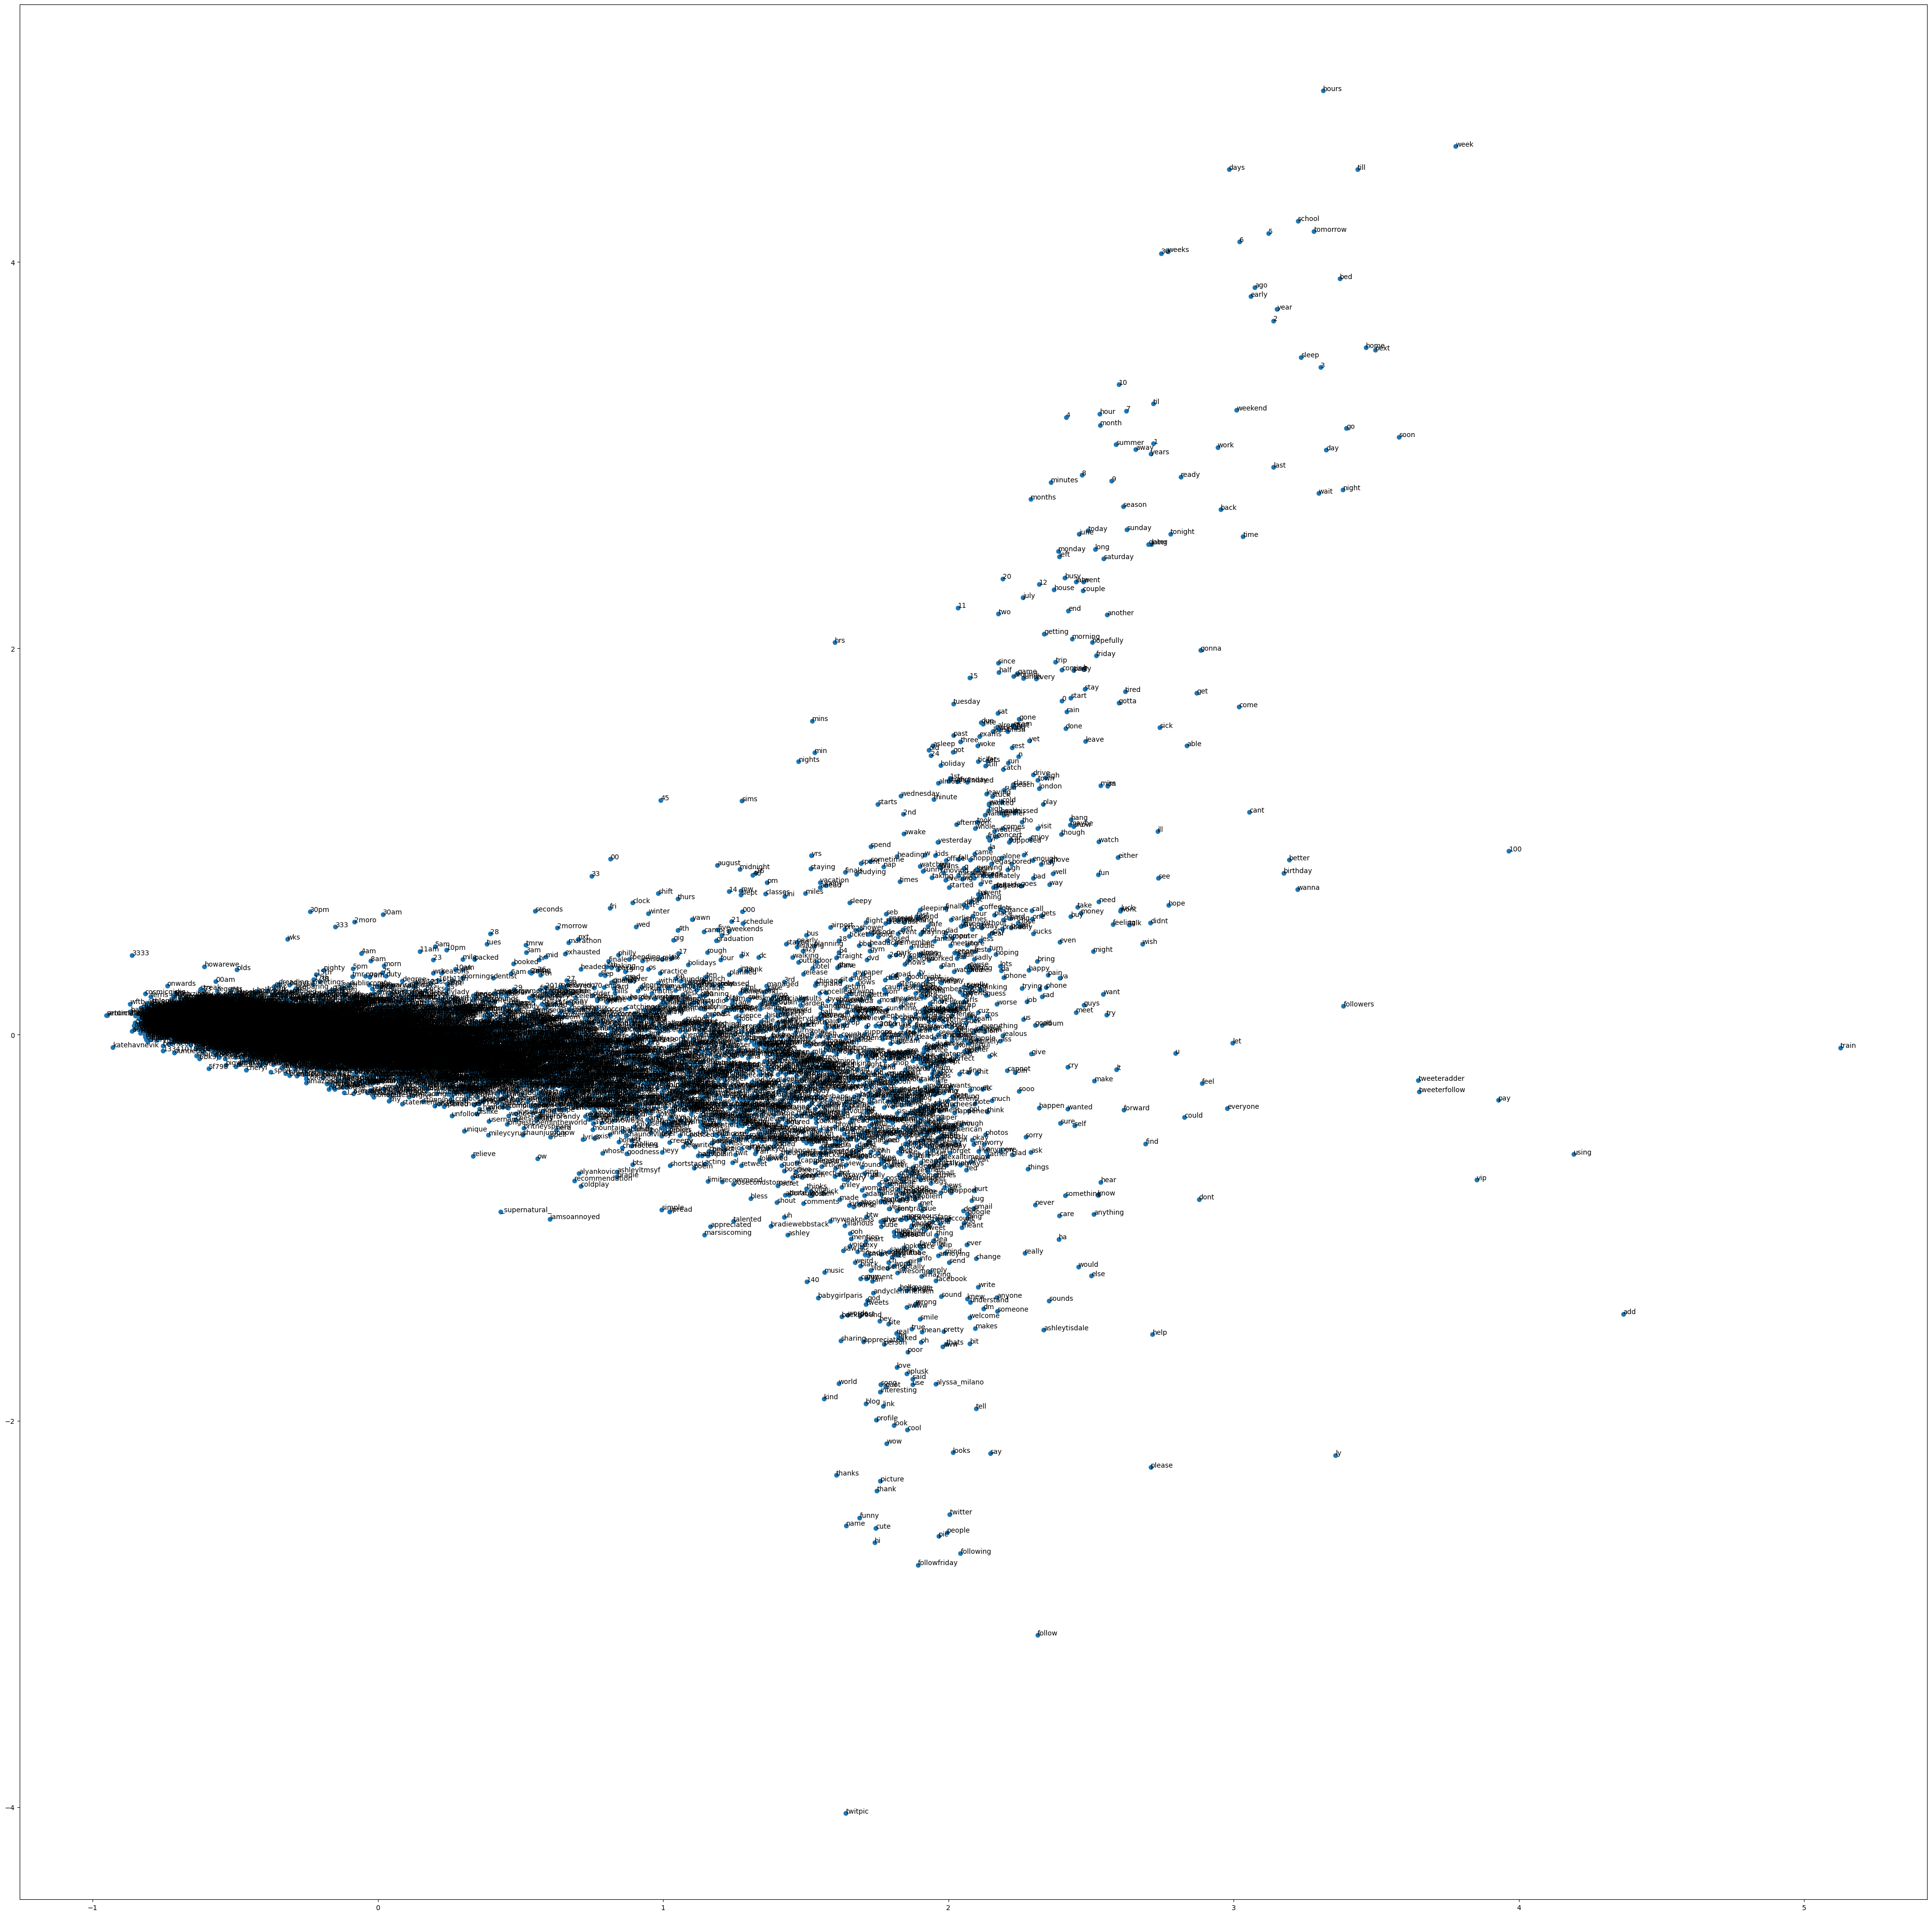

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure()
#zoom out of the graph to see the words more clearly
fig.set_figheight(50)
fig.set_figwidth(50)
ax = fig.add_subplot(1, 1, 1)
#label the points with their respective words
for word, x, y in zip(PCA_data_labeled['word'], PCA_data_labeled['x_values'], PCA_data_labeled['y_values']):
    ax.annotate(word, (x, y))

ax.scatter(PCA_data_labeled['x_values'], PCA_data_labeled['y_values'])

In [69]:
#Run k-means and color the the points in the graph to their respective cluster
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(vectors)
y_kmeans = kmeans.predict(vectors)
ax.scatter(vectors[:, 0], vectors[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

c:\Users\corie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


##Run A-propri on the word vetors, to see which words are most often used together

In [60]:
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import array_distinct
aprioriDF = dataset.withColumn("wordsWithoutDupes", array_distinct("filtered"))
#Number of unique words
fpGrowth = FPGrowth(itemsCol="wordsWithoutDupes", minSupport=0.002, minConfidence=0.2)
apriori_model = fpGrowth.fit(aprioriDF)

In [61]:
from pyspark.sql.functions import desc
apriori_model.freqItemsets.sort(desc("freq")).show(apriori_model.freqItemsets.count())
print("Number of frequent itemsets: " + str(apriori_model.freqItemsets.count()))
apriori_model.associationRules.show()
print("Number of association rules: " + str(apriori_model.associationRules.count()))

+------------------+----+
|             items|freq|
+------------------+----+
|            [good]|5677|
|            [like]|5284|
|             [get]|5123|
|             [lol]|5118|
|            [know]|4442|
|               [u]|4331|
|            [quot]|4269|
|            [love]|4264|
|          [thanks]|4077|
|             [one]|3572|
|              [go]|3487|
|             [day]|3310|
|             [see]|3176|
|            [well]|3110|
|            [time]|2973|
|             [got]|2939|
|              [oh]|2896|
|           [think]|2833|
|            [haha]|2779|
|              [im]|2760|
|          [really]|2660|
|            [hope]|2653|
|           [going]|2601|
|            [work]|2543|
|           [sorry]|2497|
|           [still]|2376|
|            [back]|2364|
|            [yeah]|2329|
|            [want]|2249|
|           [would]|2231|
|           [today]|2225|
|            [much]|2206|
|           [great]|2133|
|            [need]|2023|
|            [miss]|2005|
|           

##Train the model to predict Sentiment on the test data

In [ ]:
#Split training and Testing
split_data=train.randomSplit([0.7,0.3])
trainSplit=split_data[0]

#label in test renamed to true label
testSplit=split_data[1]

trainSplit = pipeline.transform(trainSplit).select("Sentiment", "filtered", "features")
testSplit = pipeline.transform(testSplit).select("Sentiment", "filtered", "features")

#Count the number of training tweets and testing tweets
print("Number of training tweets: " + str(trainSplit.count()))
print("Number of testing tweets: " + str(testSplit.count()))

trainSplit.show(5, truncate=False)
testSplit.show(5, truncate=False)

Number of training tweets: 70086
Number of testing tweets: 29914
+---------+-----------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sentiment|filtered                                                                                       |features                                                                                                                                                                   |
+---------+-----------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |[sad, apl, friend]                                                                  

In [ ]:
lr = LogisticRegression(labelCol = 'Sentiment', featuresCol='features', maxIter=100, regParam=0.01)
lrModel = lr.fit(trainSplit)
print("Done")

raw_prediction = lrModel.transform(testSplit)
raw_prediction.printSchema()

Done
root
 |-- Sentiment: integer (nullable = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
Final_prediction = raw_prediction.select("filtered", "prediction", "Sentiment")
Final_prediction.show(n=4, truncate = False)

+---------------------------------------------------------------------------+----------+---------+
|filtered                                                                   |prediction|Sentiment|
+---------------------------------------------------------------------------+----------+---------+
|[missed, new, moon, trailer]                                               |0.0       |0        |
|[handed, uniform, today, miss, already]                                    |0.0       |1        |
|[weekend, sucked, far]                                                     |0.0       |0        |
|[awhhe, man, m, completely, useless, rt, funny, twitter, http, myloc, 27hx]|0.0       |0        |
+---------------------------------------------------------------------------+----------+---------+
only showing top 4 rows



In [ ]:
#Count the accuracy
correctPrediction = Final_prediction.filter(Final_prediction['prediction'] == Final_prediction['Sentiment']).count()
print("Number of correct predictions: " + str(correctPrediction))
Accuracy = correctPrediction/testSplit.count()*100
print("Accuracy: " + str(Accuracy))


Number of correct predictions: 20842
Accuracy: 69.67306277996924
